# Image Processing Algorithms

In [1]:
%matplotlib inline
from scipy.ndimage.filters import convolve
from skimage.filters import gaussian
import numpy as np
from numpy.random import default_rng
from random import randint
from ipywidgets import interact
from matplotlib import cm
from matplotlib import image as img
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

# Constants
RED = 0
GREEN = 1
BLUE = 2
ALPHA = 3
CHANNELS = [RED, GREEN, BLUE, ALPHA]

# Normalize image
normalize = lambda image: (image - image.min()) / (image.max() - image.min())

C:\Users\Anshul Kharbanda\AppData\Local\Temp\ipykernel_13336\592770212.py:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


First we need to load an image of my beautiful face

Image: float32 (3088, 2316, 4)


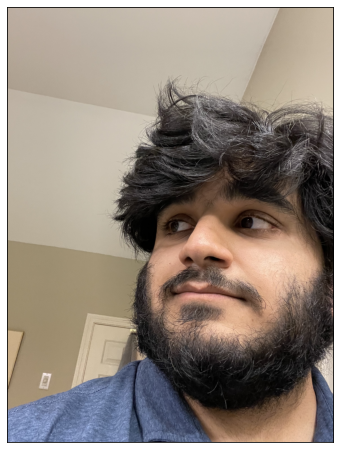

In [2]:
photo = img.imread('data/melol.png')
print('Image:', photo.dtype, photo.shape)
plt.figure();
plt.imshow(photo)
plt.show();

## Screen-Door effect Filter

Shift color channels. Get a retro TV effect. Since most analog TV's are scanned horizontally, my prediction is that the distortion will most likely be horizontal rather than vertical.

This filter is randomized. Rerun the cell to get a new image.

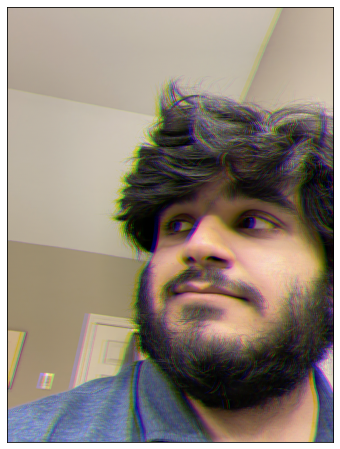

In [3]:
# Shifts
shift = default_rng().integers(low=-25, high=25, size=3)

# Do channel shift
screendoor = np.array(photo)
for chan in range(3):
    if shift[chan] > 0:
        screendoor[:,:-shift[chan],chan] = photo[:,shift[chan]:,chan]
    elif shift[chan] < 0:
        screendoor[:,-shift[chan]:,chan] = photo[:,:shift[chan],chan]

# Show photo
plt.figure()
plt.imshow(screendoor);

## Corrupted Pixels

Randomly invert lines of pixels

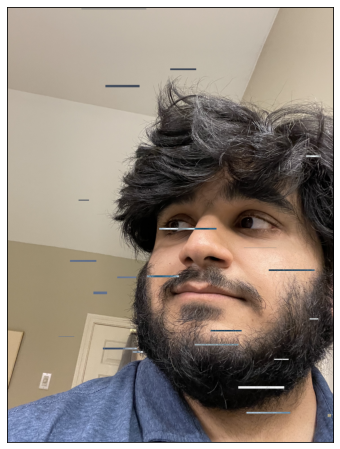

In [4]:
# Parameters
max_streaks = 30
max_length = 500
max_width = 20

# Random row to corrupt
corrupted = np.array(photo)
streaks = randint(0, max_streaks)
for _ in range(streaks):
    ib = randint(0, corrupted.shape[1])
    ie = randint(ib, min(ib + max_length, corrupted.shape[1]))
    jb = randint(0, corrupted.shape[0])
    je = randint(jb, min(jb + max_width, corrupted.shape[0]))
    corrupted[jb:je,ib:ie,0:3] = 1 - corrupted[jb:je,ib:ie,0:3]

# Show photo
plt.figure()
plt.imshow(corrupted);

I would like to do this around the face, like a silhouette

## Edge Filters

Going to try and detect edges. Will use grayscale for now. We take two kernels (a horizontal and a vertical kernel), and convolve over the image with each. Then we treat each pixel as a 2D vector with the x coordinate in one image and the y coordinate in another (you may also see this as a 2-channel image). We get the norm or magnitude of that vector to get our final edge detection. I discovered it's important to take the norm of both edges which will result in a clear edge detection. Otherwise, the distribution of values for each individual processed image is clustered really close to the mean, so each image individually looks gray.

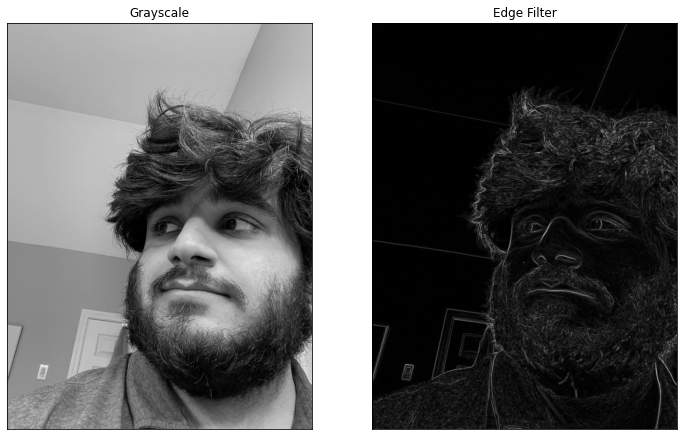

In [5]:
# Grayscale photo
grayscale = np.sum(photo, axis=2)

# Horizontal edge detector
h_edge_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)
v_edge_kernel = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
], dtype=np.float64)

# Run filter
blurred = gaussian(grayscale, sigma=3)
h_edge = convolve(blurred, h_edge_kernel)
v_edge = convolve(blurred, v_edge_kernel)
edge = np.sqrt(h_edge**2 + v_edge**2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(grayscale)
plt.title('Grayscale')
plt.subplot(1,2,2)
plt.imshow(edge)
plt.title('Edge Filter')
plt.show();

So now we have this edge detection data, we can combine it with our original image to produce a few effects. I have four of them down below

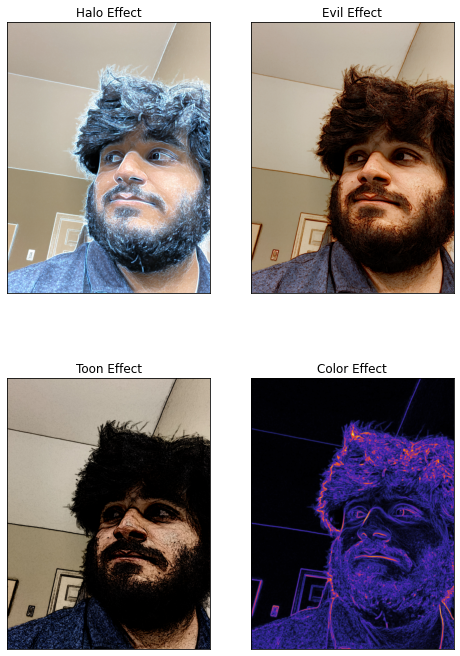

In [6]:
# Halo effect
halo = 5 * np.array([[[ 0.1, 0.2, 0.3, 0.0 ]]])
halo = np.expand_dims(edge, axis=2) * halo
halo_effect = (photo + halo).clip(0, 1);

# Evil effect
evil = 5 * np.array([[[ -0.1, -0.2, -0.3, 0.0 ]]])
evil = np.expand_dims(edge, axis=2) * evil
evil_effect = (photo + evil).clip(0, 1)

# Scanner darkly effect
toon = 3 * np.array([[[ -1, -1, -1, 0.0 ]]])
toon = np.expand_dims(edge, axis=2) * toon
toon_effect = (photo + toon).clip(0, 1)

# Colormap effect
edge_blurred = gaussian(edge, sigma=3)
viridis = cm.get_cmap('CMRmap')
colr_effect = viridis(edge_blurred / np.max(edge_blurred))

# Plot all
plt.figure(figsize=(8,12))
plt.subplot(2,2,1)
plt.imshow(halo_effect)
plt.title('Halo Effect')
plt.subplot(2,2,2)
plt.imshow(evil_effect)
plt.title('Evil Effect')
plt.subplot(2,2,3)
plt.imshow(toon_effect)
plt.title('Toon Effect')
plt.subplot(2,2,4)
plt.imshow(colr_effect)
plt.title('Color Effect')
plt.show();

## Duotone Image

This should be straightforward, take the grayscale and map each value to a color in a gradient colormap.
We take the normalized grayscale image and treat it as an "alpha" parameter, which we use to interpolate between two points.

The photo of me is pretty crowded in terms of grayscale images, so I'm also going to use this photo of Kanye West, since it has a clear foreground and background (or positive and negative space as they say in photography)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


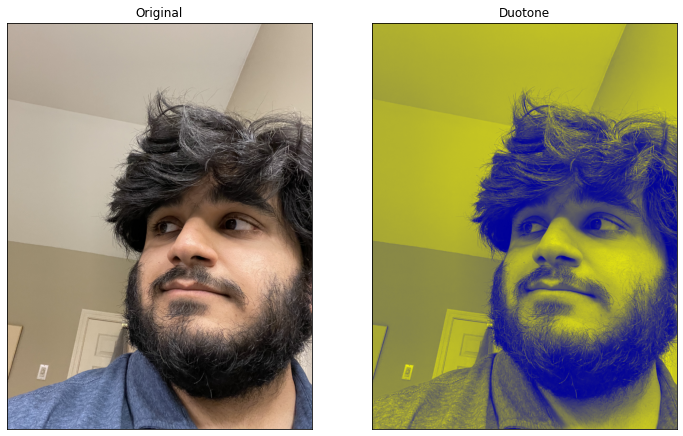

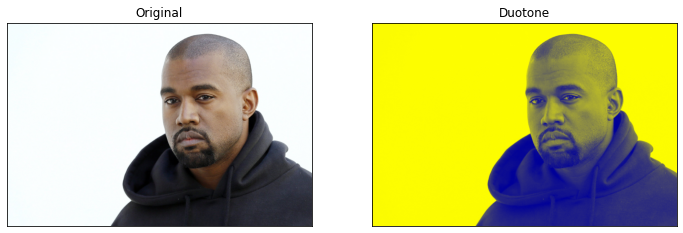

In [12]:
# Duotone colors
colors = np.array([
    [[[ 0, 0, 0.6, 1 ]]],
    [[[ 1, 1, 0,   1 ]]]
])

# Duotone my image
alpha_me = np.expand_dims(normalize(np.sum(photo, axis=2)), axis=2)
duotone_me = colors[0] * (1 - alpha_me) + colors[1] * alpha_me;

# Run same algorithm for kanye
original_ye = img.imread('data/kanye.jpeg');
alpha_ye = np.expand_dims(normalize(np.sum(original_ye, axis=2)), axis=2)
duotone_ye = colors[0] * (1 - alpha_ye) + colors[1] * alpha_ye;

plt.figure()
plt.subplot(1,2,1)
plt.imshow(photo)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(duotone_me)
plt.title('Duotone')
plt.show();

plt.figure()
plt.subplot(1,2,1)
plt.imshow(original_ye)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(duotone_ye)
plt.title('Duotone')
plt.show();